In [2]:
import sys
import os
import theano
import theano.tensor as tt
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import PDMP_ll as ll
import cPickle as pickle
from IPython.display import display
#from IPython.html.widgets import *
from ipywidgets import widgets
from ipywidgets import interact
from sklearn import manifold

In [37]:
trace = pickle.load(open("all_PYY_4hr_trace.p", "rb"))
subj_data = pickle.load(open("all_PYY_4hr_subj.p", "rb"))

In [38]:
import matplotlib as mpl
import matplotlib.cm as cm

subj_labels = []

for i in subj_data:
    subj_labels.append(i[1].split('_'))
    
subj_labels = np.array(subj_labels)
print subj_labels[:,1]

rat_idx = np.unique(trace['theta1'][0,:], return_index=True)[1]
rat_idx = sorted(rat_idx)

def get_indiv(trace, idx):
    num_samples = trace.shape[0]
    
    data_holder = []
    for i in range(0, num_samples):
        data_holder.append(trace[i, idx])
    
    data = np.stack(data_holder)
    return data

## Create metadata holder
metadata = []
groups = []

for i in subj_data:
    x = []
    group = i[0].split('/')[1]
    x.append(group)
    x += i[1].split('_')
    
    metadata.append(x)
    
    if group not in groups:
        groups.append(group)
        
group_id_dict = {}
for i, group_name in enumerate(groups):
    group_id_dict[i] = group_name
    
group_list = np.arange(len(groups))
        
## Create group colourmapper
norm = mpl.colors.Normalize(vmin = 0,
                            vmax = len(groups))

cmap = cm.Paired

group_col = cm.ScalarMappable(norm=norm, cmap=cmap)

## Create dose colourmapper
norm = mpl.colors.PowerNorm(vmin = 0.0,
                            vmax = 300,
                            gamma = 0.1)

cmap = cm.plasma

dose_col = cm.ScalarMappable(norm=norm, cmap=cmap)

## Create amount & rate colourmappers
durs = []
def qty_from_file(filename):
    data = np.loadtxt(filename,delimiter='\t',usecols=(0,1,2,3,4))

    f_lengths = data[:,0]
    g_starts = data[:,1]
    rates = data[:,2]
    p_lengths = data[:,3]
    g_ends = data[:,4]
    
    qty = rates*f_lengths
    dur = sum(f_lengths) + sum(p_lengths)
    durs.append(dur)
    return sum(qty)

## Import amounts
amts_save = []
for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    data = subj_labels[i]    
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    amt = qty_from_file(path + '/' + filename)
    
    amts_save.append(amt)
    
amt_norm = mpl.colors.Normalize(vmin = min(amts_save),
                                vmax = max(amts_save))

cmap = cm.plasma

amt_col = cm.ScalarMappable(norm=amt_norm, cmap=cmap)
"""
fig, ax = plt.subplots(1)
ax.scatter(durs, amts_save)
ax.set_ylim((min(amts_save), max(amts_save)))
"""
## Create day/night specific amount colourmapper
day_amts = []
night_amts = []
for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    data = subj_labels[i]
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    
    if data[3] == 'L':
        day_amts.append(qty_from_file(path + '/' + filename))
        
    else:
        night_amts.append(qty_from_file(path + '/' + filename))
    
day_norm = mpl.colors.Normalize(vmin = min(day_amts),
                                vmax = max(day_amts))
    
night_norm = mpl.colors.Normalize(vmin = min(night_amts),
                                  vmax = max(night_amts))

cmap = cm.plasma

day_amt_col = cm.ScalarMappable(norm=day_norm, cmap=cmap)
night_amt_col = cm.ScalarMappable(norm=night_norm, cmap=cmap)

## Create day/night line and marker style
period_ms = {'L':'o', 'D':'^'}
period_ls = {'L':'-', 'D':'--'}

## Create drug-dependent dose colourmappers
## PYY
PYY_dict = {1.5:4, 7.5:7, 300.0:10}
PYY_norm = mpl.colors.Normalize(vmin = 0.0,
                                vmax = 10)

PYY_cmap = cm.Greens

PYY_dose_col = cm.ScalarMappable(norm=PYY_norm, cmap=PYY_cmap)

## LiCL
LiCL_norm = mpl.colors.Normalize(vmin = 0.0,
                                 vmax = 64.0)

LiCL_cmap = cm.Reds

LiCL_dose_col = cm.ScalarMappable(norm=LiCL_norm, cmap=LiCL_cmap)

## Lep
Lep_norm = mpl.colors.Normalize(vmin = 0.0,
                                vmax = 2.0)

Lep_cmap = cm.coolwarm

Lep_dose_col = cm.ScalarMappable(norm=Lep_norm, cmap=Lep_cmap)

## Cage ID colourmap
cage_IDs = []
for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    data = subj_labels[i]
    path = 'all_data/' + '_'.join(data[0:4])
    filename = '_'.join(data)
    
    cage_IDs.append(float(data[4]))
    
cage_norm = mpl.colors.Normalize(vmin = min(cage_IDs),
                                 vmax = max(cage_IDs))
cage_cmap = cm.tab20

cage_col = cm.ScalarMappable(norm=cage_norm, cmap=cage_cmap)

def dose_colour(group_data):
    if group_data[0] == 'saline' and group_data[2] == 'N':
        c_dose = 'k'

    elif group_data[0] == 'saline' and group_data[2] == 'R':
        c_dose = 'b'

    elif group_data[0] == 'LiCL':
        c_dose = LiCL_dose_col.to_rgba(dose)

    elif group_data[0] == 'PYY':
        c_dose = PYY_dose_col.to_rgba(PYY_dict[dose])

    elif group_data[0] == 'Lep':
        c_dose = 'y'

    else:
        print "ERROR", data

    return c_dose

['300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0'
 '300.0' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '1.5'
 '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5'
 '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '7.5' '1.5' '1.5' '1.5'
 '1.5' '1.5' '1.5' '1.5' '1.5' '1.5' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0' '300.0'
 '300.0' '300.0' '300.0' '300.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0'
 '0.0' '0.0' '0.0']


# Create dataset

In [47]:
import numpy as np
from sklearn import preprocessing

thetas = ['theta1', 'theta3', 'theta4', 'theta5', 'theta6', 'theta7', 'theta8', 'theta9']

data = []

for theta in thetas:
    data.append(np.mean(get_indiv(trace[theta], rat_idx), axis=0))

data = np.array(data).T

data = preprocessing.scale(data)

# t-SNE

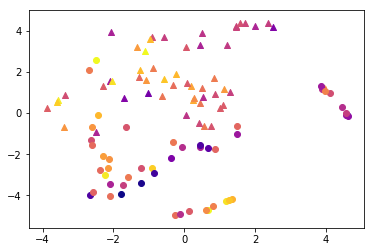

In [64]:
model = manifold.TSNE(n_components=2,
                      learning_rate=10,
                      n_iter=1000000)
X = model.fit_transform(data)

for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    subj_data = subj_labels[i]
    dose = float(subj_data[1])

    if subj_data[0] == 'saline' and subj_data[2] == 'N':
        c = 'k'
        #continue
        
    elif subj_data[0] == 'saline' and subj_data[2] == 'R':
        c = 'b'
        #continue
        
    elif subj_data[0] == 'PYY':
        c = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue
        
    else:
        print "ERROR", subj_data
        
    ## Get feeding data
       
    path = 'all_data/' + '_'.join(subj_data[0:4])
    filename = '_'.join(subj_data)
    amt = qty_from_file(path + '/' + filename)

    c = amt_col.to_rgba(amt)
    
    ms = period_ms[subj_data[3]]

    plt.scatter(X[i,0], X[i,1], c=c, marker=ms)
    
plt.show()

# Isomap

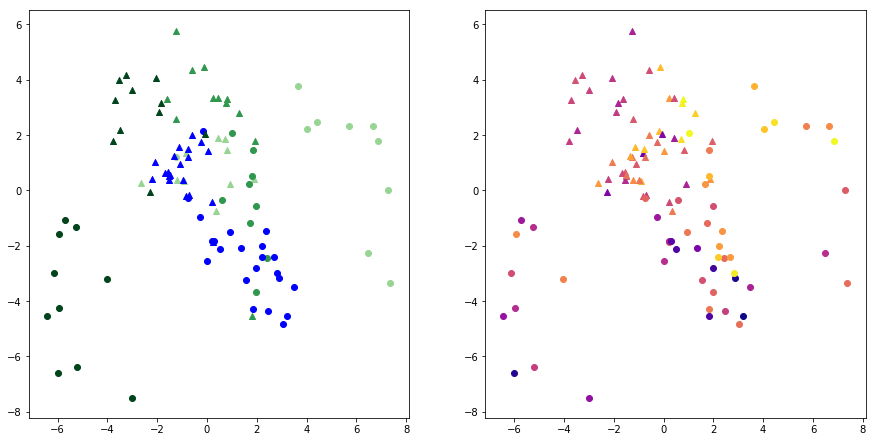

In [62]:
model = manifold.Isomap(6, n_components=2)
X = model.fit_transform(data)
fig, axes = plt.subplots(1,2, figsize=(15, 7.5))
for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    subj_data = subj_labels[i]
    dose = float(subj_data[1])

    if subj_data[0] == 'saline' and subj_data[2] == 'N':
        c = 'k'
        #continue
        
    elif subj_data[0] == 'saline' and subj_data[2] == 'R':
        c = 'b'
        #continue
        
    elif subj_data[0] == 'PYY':
        c = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue
        
    else:
        print "ERROR", subj_data
        
    axes[0].scatter(X[i,0], X[i,1], c=c, marker=ms)
        
    ## Get feeding data
    path = 'all_data/' + '_'.join(subj_data[0:4])
    filename = '_'.join(subj_data)
    amt = qty_from_file(path + '/' + filename)

    c = amt_col.to_rgba(amt)
    
    
    ms = period_ms[subj_data[3]]

    
    axes[1].scatter(X[i,0], X[i,1], c=c, marker=ms)
    
plt.show()

# Spectral embedding

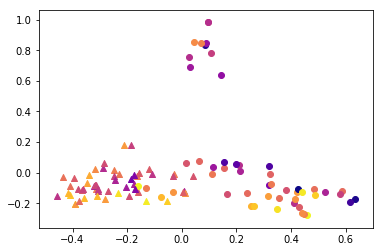

In [66]:
model = manifold.SpectralEmbedding(n_components=2)
X = model.fit_transform(data)

for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    subj_data = subj_labels[i]
    dose = float(subj_data[1])

    if subj_data[0] == 'saline' and subj_data[2] == 'N':
        c = 'k'
        #continue
        
    elif subj_data[0] == 'saline' and subj_data[2] == 'R':
        c = 'b'
        #continue
        
    elif subj_data[0] == 'PYY':
        c = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue
        
    else:
        print "ERROR", subj_data
        
    ## Get feeding data
           
    path = 'all_data/' + '_'.join(subj_data[0:4])
    filename = '_'.join(subj_data)
    amt = qty_from_file(path + '/' + filename)
    c = amt_col.to_rgba(amt)
    
    
    ms = period_ms[subj_data[3]]

    plt.scatter(X[i,0], X[i,1], c=c, marker=ms)
    
plt.show()

# Locally linear embedding - looks weird

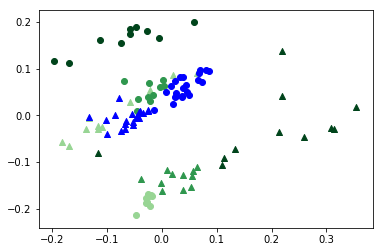

In [34]:
model = manifold.LocallyLinearEmbedding(13, n_components=2)
X = model.fit_transform(data)

for i, idx in enumerate(rat_idx):
    ## Formatting stuff
    subj_data = subj_labels[i]
    dose = float(subj_data[1])

    if subj_data[0] == 'saline' and subj_data[2] == 'N':
        c = 'k'
        #continue
        
    elif subj_data[0] == 'saline' and subj_data[2] == 'R':
        c = 'b'
        #continue
        
    elif subj_data[0] == 'PYY':
        c = PYY_dose_col.to_rgba(PYY_dict[dose])
        #continue
        
    else:
        print "ERROR", subj_data
    
    ms = period_ms[subj_data[3]]

    plt.scatter(X[i,0], X[i,1], c=c, marker=ms)
    
plt.show()